In [1]:
%pylab inline
import sys
sys.path.append("../")

Populating the interactive namespace from numpy and matplotlib


In [2]:
pkg = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01_2.gpkg"

In [3]:
import geopandas

/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

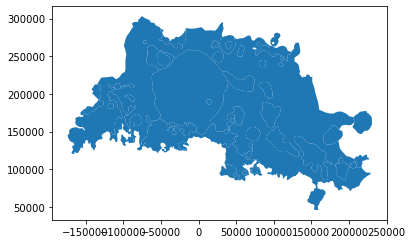

In [4]:
polygons = geopandas.read_file(pkg)
import mappy
polygons.plot()

In [5]:
exploded = mappy.geom_ops.explode_multipolygons(polygons)

In [14]:
for e in exploded.geometry:
    if not e.is_valid:
        print(e)

In [10]:
import topojson
# tj = topojson.Topology(polygons,prequantize=False,topoquantize=True, shared_coords=False, toposimplify=True, presimplify=False)
tj = topojson.Topology(exploded, prequantize=False)

tj = tj.toposimplify(0.1).topoquantize(1e12)
asgdf = tj.to_gdf()
asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

In [11]:
tj

Topology(
{'arcs': [[[530772123415, 829070987501], [-4118474281, 1617816956]],
          [[526653649134, 830688804457], [-2867941666, 4631709873]],
          [[204346261285, 447153741360], [78853879, -3508224857]],
          [[934598177192, 244015044600],
           [859724037, 509015662],
           [2522501430, -1548635195]],
          [[943771723646, 247020888762],
           [-419536743, -3644992182],
           [1499546536, -3734960701]],
          [[944851733439, 239640935879], [3509712022, -1835493209]],
          [[947728979842, 227868597733], [1289162190, -6330981228]],
          [[937885076263, 211856151230],
           [-1099332126, -324150314],
           [-238087242, 3883306295]],
          [[698941314780, 896532844577],
           [-2950347830, -6508345142],
           [-2595687769, -6533093669],
           [-2362526427, -3658919654],
           [1397914328, -5258769406],
           [543032767, -3837675878],
           [-1028980498, -7698847648],
           [-3146741359, 

In [97]:
import fiona
from shapely.geometry import LineString, Point
def polygon_to_vertices(pol):

    return np.array(pol.exterior)

def explode_polygons_to_line_segments(dataframe, dps=5):
    """
    Explode POLYGON layer to distinct edge segments, together
    with counts. (e.g. for a country map, 1=coastline and 2=land border)
    :param filename: Filename for source
    :param dps: Number decimal places to round to (suggest min 5)
    :return: 
    """
    segs = {}
    geoms = {}
   
    for feature in dataframe.geometry:
        # only works on exterior for now
        coords = polygon_to_vertices(feature)
        coords_rounded = []
        for x, y in coords:
            rounded_x = round(x, dps)
            rounded_y = round(y, dps)
            coords_rounded.append((rounded_x, rounded_y))
        for i in range(0, len(coords_rounded)-1):
            x1, y1 = coords_rounded[i]
            x2, y2 = coords_rounded[i+1]
            # deduplicate lines which overlap but go in different directions
            if (x1 < x2):
                key = (x1, y1, x2, y2)
            else:
                if (x1 == x2):
                    if (y1 < y2):
                        key = (x1, y1, x2, y2)
                    else:
                        key = (x2, y2, x1, y1)
                else:
                    key = (x2, y2, x1, y1)
            if key not in segs:
                segs[key] = 1
            else:
                segs[key] += 1
            line = LineString([Point(x1,y1), Point(x2,y2)])
            geoms[key] = line.wkt
    return geoms, segs



In [99]:
geoms, segs = explode_polygons_to_line_segments(exploded)

<ipython-input-97-c998fa00eb0c>:21: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords = polygon_to_vertices(feature)


In [106]:
np.array(key).reshape((2,2))

array([[ 38819.25457, 269349.32696],
       [ 40034.06533, 269606.18478]])

/home/luca/.local/lib/python3.8/site-packages/geopandas/plotting.py:203: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  segments = [np.array(linestring)[:, :2] for linestring in geoms]


,geometry
0,"LINESTRING (38819.255 269349.327, 40034.065 26..."
1,"LINESTRING (40034.065 269606.185, 41747.562 26..."
2,"LINESTRING (41747.562 269815.680, 42850.042 26..."
3,"LINESTRING (42850.042 269602.491, 43525.229 26..."
4,"LINESTRING (43525.229 269434.932, 44327.510 26..."
...,...
3330,"LINESTRING (-80176.065 298787.850, -78451.938 ..."
3331,"LINESTRING (-78451.938 300028.553, -75347.773 ..."
3332,"LINESTRING (-75347.773 303449.016, -70912.386 ..."
3333,"LINESTRING (-70912.386 300710.176, -68701.430 ..."


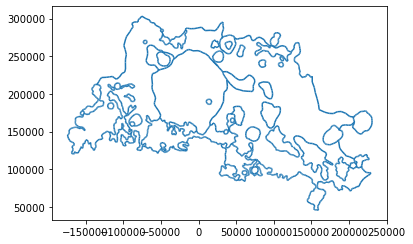

In [110]:
from shapely.geometry import LineString
lines = []
for key in segs:
    
    l = LineString(np.array(key).reshape((2,2)))
    lines.append(l)
    
asgpd = geopandas.GeoDataFrame(geometry = lines)
asgpd.plot()

In [112]:
asgpd.to_file("testfile.gpkg", layer="lines", driver="GPKG")

In [92]:
for f in exploded.geometry:
    dd = f.exterior
    print(f.exterior)
    polygon_to_vertices(f)

LINEARRING (38819.25457381028 269349.3269589487, 40034.06533187382 269606.1847793498, 41747.56188399224 269815.6796881245, 42850.04228429578 269602.4911737421, 43525.22923270824 269434.931605227, 44327.51039907572 268049.5304356206, 44700.30944274109 266553.1471841169, 44219.03549278916 265109.7687130699, 43311.66382754749 263712.1817355353, 42367.01329490948 262118.5285234197, 42209.0112319476 260826.1320762894, 41521.33978821287 259816.4499144006, 40734.38777706477 259396.6934605345, 39068.62906249243 259813.6419513682, 37908.66095347713 261007.3396895666, 36785.91542990361 262435.3105728075, 36345.64704000035 264559.680652138, 35644.26258642612 265588.8179604624, 35228.52115270768 266731.6446935642, 35631.44473754445 267824.4668422789, 37241.99983795495 268508.7343993708, 38819.25457381028 269349.3269589487)


TypeError: 'LinearRing' object is not iterable

In [96]:
np.array(dd.coords)

array([[ 38819.25457381, 269349.32695895],
       [ 40034.06533187, 269606.18477935],
       [ 41747.56188399, 269815.67968812],
       [ 42850.0422843 , 269602.49117374],
       [ 43525.22923271, 269434.93160523],
       [ 44327.51039908, 268049.53043562],
       [ 44700.30944274, 266553.14718412],
       [ 44219.03549279, 265109.76871307],
       [ 43311.66382755, 263712.18173554],
       [ 42367.01329491, 262118.52852342],
       [ 42209.01123195, 260826.13207629],
       [ 41521.33978821, 259816.4499144 ],
       [ 40734.38777706, 259396.69346053],
       [ 39068.62906249, 259813.64195137],
       [ 37908.66095348, 261007.33968957],
       [ 36785.9154299 , 262435.31057281],
       [ 36345.64704   , 264559.68065214],
       [ 35644.26258643, 265588.81796046],
       [ 35228.52115271, 266731.64469356],
       [ 35631.44473754, 267824.46684228],
       [ 37241.99983795, 268508.73439937],
       [ 38819.25457381, 269349.32695895]])

In [74]:
o

array([[[ 38819.25457381, 269349.32695895],
        [ 40034.06533187, 269606.18477935],
        [ 41747.56188399, 269815.67968812],
        [ 42850.0422843 , 269602.49117374],
        [ 43525.22923271, 269434.93160523],
        [ 44327.51039908, 268049.53043562],
        [ 44700.30944274, 266553.14718412],
        [ 44219.03549279, 265109.76871307],
        [ 43311.66382755, 263712.18173554],
        [ 42367.01329491, 262118.52852342],
        [ 42209.01123195, 260826.13207629],
        [ 41521.33978821, 259816.4499144 ],
        [ 40734.38777706, 259396.69346053],
        [ 39068.62906249, 259813.64195137],
        [ 37908.66095348, 261007.33968957],
        [ 36785.9154299 , 262435.31057281],
        [ 36345.64704   , 264559.68065214],
        [ 35644.26258643, 265588.81796046],
        [ 35228.52115271, 266731.64469356],
        [ 35631.44473754, 267824.46684228],
        [ 37241.99983795, 268508.73439937],
        [ 38819.25457381, 269349.32695895]]])